In [ ]:
# TODO: Katya
# Fig S2-S3-S4, 4

# Datasets Class and Data Analysis  

In our work we investigated 5 datasets that contain several types of movements and diverse brain areas recorded (for more information about datasets check our paper or table "**Datasets Used in Study**" in github repository main page).

Here I demonstrate how to use special dataset class called `NeuralDataset` and how create your own, if you'd like to analyze (with help of **Gyration Plane** and not only that) some other datasets. And how to create **figures S2-S3-S4** and **fig. 4** from our paper.

#### 1. Download datasets

(Gallego: Not all files are uploaded here, since the full size of dataset is 9 Gb. )

In [25]:
!bash prepare_data.sh

prepare_data.sh: line 2: gdown: command not found
Archive:  datasets.zip
  inflating: datasets/churchland2012.mat  
  inflating: datasets/datasets_info.txt  
  inflating: datasets/m1sc_suresh2020/Dataset4_Monkey1_Session1_GraspDataSimultaneousRecording.mat  
  inflating: datasets/m1sc_suresh2020/Dataset3_Monkey3_Session1_GraspDataSimultaneousRecording.mat  
  inflating: datasets/m1sc_suresh2020/Dataset6_Monkey5_Session1_ReachDataSimultaneousRecording.mat  
  inflating: datasets/m1sc_suresh2020/ReadMe.md  
  inflating: datasets/m1sc_suresh2020/Dataset5_Monkey4_Session1_ReachDataSimultaneousRecording.mat  
  inflating: datasets/mc_kalidindi2021/README.md  
  inflating: datasets/mc_kalidindi2021/A5_data/Ayur_A5.mat  
  inflating: datasets/mc_kalidindi2021/A5_data/Patch_A5.mat  
  inflating: datasets/mc_kalidindi2021/A2_data/Ayur_A2.mat  
  inflating: datasets/mc_kalidindi2021/MC_data/Ayur_Data.mat  
  inflating: datasets/mc_kalidindi2021/MC_data/Xander_Data.mat  
  inflating: datasets/mc_

#### 2. Import NeuralDataset class and specify the directory of dataset

In this example we will use only dataset from "*Neural Population Dynamics During Reaching*" by Churchland et al. This dataset contains reaching movements recorded in M1 and PMd brain areas. All data for this dataset are recorded in one matlab file. Firstly we have to load it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.datasets import (
    NeuralDataset,
    ReachingChurchland,
)

dataset = ReachingChurchland(dataset_dir='datasets/')
dataset.load_data(dataset_name='churchland2012.mat')

File churchland2012.mat successfully loaded!


Then, we have to pre-process loaded matlab file. In our case, with Churchland's dataset, we don't have to make ant complicated pre-processing. However other datasets (e.g. `GraspingSuresh`) requires a lot of work to do before using it. You can check out all pre-processing in `utils/datasets.py`.

In [2]:
dataset.preprocess_data()

No preprocessing needed! Loaded.


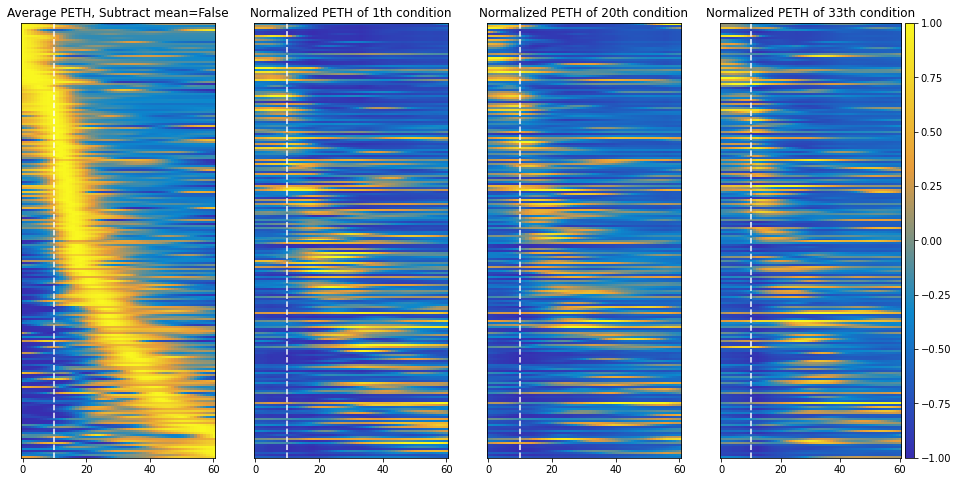

In [3]:
# Now you can use all common methods of NeuralDataset class
dataset.plot_peth(subtract_mean=False, cond_list=[1,20,33],
                  sort_individ=False, save_name=None)

jPCA


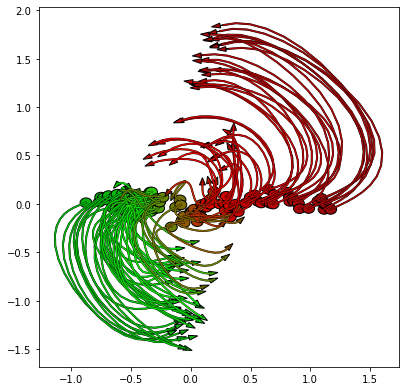

In [14]:
dataset.plot_jpca(tstart=0, tend=20, subtract_mean=True)

Each condition for all neurons


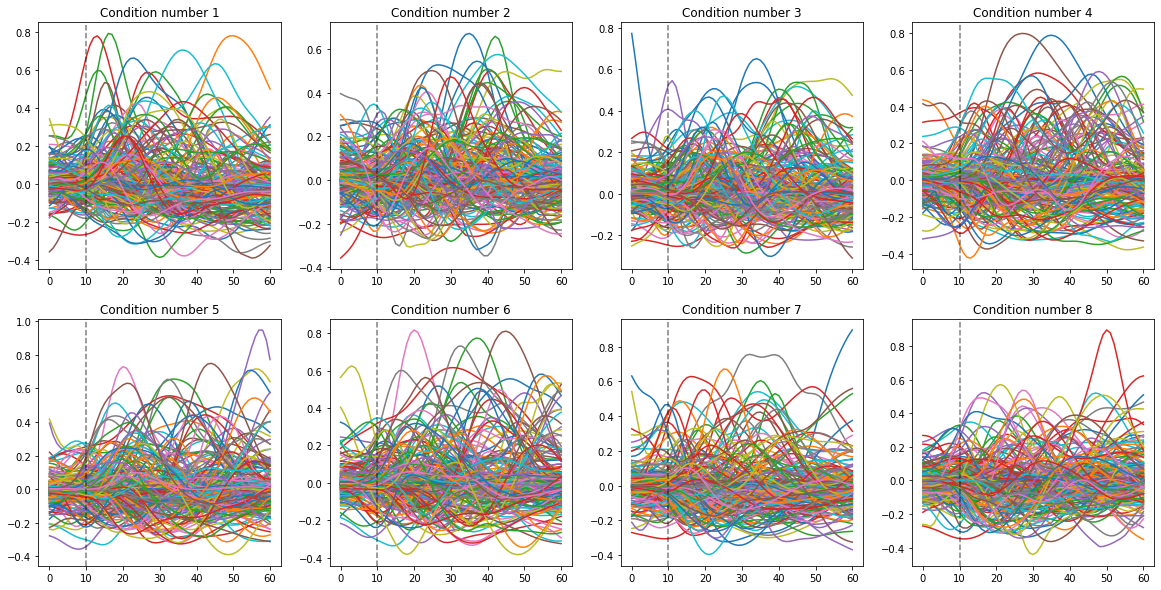

In [15]:
dataset.plot_conditions(subtract_mean=True)

In [18]:
# You can crop recordings and then reset cropped data to the original version
print(f'Original data shape: {dataset.data.shape}')
dataset.crop_data(tstart=10, tend=50)
print(f'After cropping: {dataset.data.shape}')
dataset.reset_data()
print(f'After resetting: {dataset.data.shape}')

Original data shape: (108, 61, 218)
After cropping: (108, 40, 218)
After resetting: (108, 61, 218)


jPCA after 3rd type shuffling
jPCA


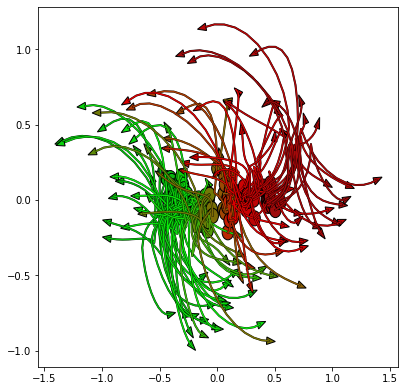

In [19]:
# You can use shufflings of data (from the Churchland paper and CMPT by Micaels et al.)
dataset.shuffle_data(shuffling_type=3)
print('jPCA after 3rd type shuffling')
dataset.plot_jpca(tstart=0, tend=20, subtract_mean=True)

In [8]:
# You can save pre-processed dataset to h5 file
dataset.reset_data()
dataset.save2h5(fname='preprocessed_reachings.h5',  fpath='datasets/')

File preprocessed_reachings.h5 successfully saved!


To create your own dataset class you have to inherit class `YourDataset(NeuralDataset)` and define 4 methods: 
- `load_data` - takes as input `dataset_name` and loads file to `self.data_dict`;

- `preprocess_data` - pre-processing of loaded `self.data_dict`, the final version of data should be written to `self.data`, `self.time` and `self.go_cue` variabele

- `create_info_dict` - create dictionary with all relevant info about dataset. This dict can be saved to .h5 file with `save2h5` method.

- `load_additional_info` - when loading from .h5 file in this method some additional info can be loaded

**Example:**

```python
class YouDataset(NeuralDataset):
    def load_data(self, dataset_name):
        self.data_dict = ...

    def preprocess_data(self, parameters):
        # Some preprocessing
        self.data = ...
        self.time = np.arange(0, 100)
        self.go_cue = self.data_dict['go_cue']

    def create_info_dict(self):
        self.info_d = {'data': self.data,
                       'time': self.time,
                       'go_cue': self.go_cue,
                       'other_params': self.params}
    
    def load_additional_info(self):
        self.other_params = self.info_d['other_params']
```

#### Shufflings

In [ ]:
# TODO

## Building Figures from Paper

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from utils.color_palettes import (
    bg_gray_color,
    jpca_palette_journ1,
    GR1, RB1, YP1, YS1,
    blue_yellow_cmap, BG1)
from utils.color_palettes import journ_color_dict, alt_colors
from utils.data_processing import load_h5_file

import numpy as np
from utils.color_palettes import blue_yellow_cmap
from utils.utils import subtract_cc_mean, soft_normalize
from utils.utils import shuffle_data, compute_curvature, pca_rotation
import jPCA
from jPCA.util import plot_projections
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from tqdm import tqdm

from utils.datasets import (
    NeuralDataset,
    GraspingSuresh,
    ReachingGallego,
    ReachingChurchland,
    ReachingKalidindi,
    BehaviouralMante, 
    )
from datasets_config import (
    dataset_params,
    data_pathes,
    )

DATA_PATH = 'images/'

### Figure 4

### Figure S2-S3

In [ ]:
all_names = ['churhc', 'grasp', 'lfp', 'khalid', 'pfc']

for nam, params, dpath in zip(all_names, dataset_params, data_pathes):
    d_dict = load_h5_file(DATA_PATH, dpath)    
    datas = d_dict["data"]
    go_cue = d_dict["align_cue_idx"]
    
    if nam == 'grasp':
        datas = d_dict["data"][:, 220:300, :]
        go_cue = go_cue - 220

    # create objects
    fig = plt.figure(figsize=(13, 6), constrained_layout=True)
    gs = GridSpec(2, 4, figure=fig) 

    # create sub plots as grid
    ax0 = fig.add_subplot(gs[:, 0])

    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2])
    ax3 = fig.add_subplot(gs[0, 3])

    ax4 = fig.add_subplot(gs[1, 1:3])
    ax5 = fig.add_subplot(gs[1, 3])

    # 0 - peth
    plot_peth(datas, go_cue, ax0, fs=params['fs'], sub_mean=False)
    ax0.set_xlabel('Time, ms', fontsize=12)
    ax0.set_title('PETH', fontsize=14)

    # 4 - curvature 
    plot_curvature(datas, go_cue, ax4, fs=params['fs'], sub_mean=False)
    ax4.set_xlabel('Time, ms', fontsize=12)
    ax4.set_title('Curvature of trajectories', fontsize=14)

    # 1 - jPCA
    build_jPCA(datas, ax1, params['ts'], params['te'], c_siz=params['c_size'], arr_siz=params['arr_size'],
                cmap=params['cmap'])
    # ax4.set_aspect('equal')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax1.spines[axis].set_linewidth(0.5)
    ax1.set_xticks([])
    ax1.set_yticks([])
    # ax1.set_xlabel('jPC1, a.u.', fontsize=9)
    # ax1.set_ylabel('jPC2, a.u.', fontsize=9)
    ax1.set_title('jPCA plane', fontsize=14)

    # 2 - PCA
    build_pca(datas, ax2, params['ts'], params['te'], c_siz=params['c_size_pca'], arr_siz=params['arr_size_pca'],
            cmap=params['cmap'])
    # ax5.set_aspect('equal')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax2.spines[axis].set_linewidth(0.5)
    ax2.set_xticks([])
    ax2.set_yticks([])
    # ax2.set_xlabel('projection onto PC1, a.u.', fontsize=10)
    # ax2.set_ylabel('projection onto PC2, a.u.', fontsize=10)
    ax2.set_title('PCA plane', fontsize=14)

    # 3 - jPCA of our fitted model
    t = np.arange(datas.shape[1])
    r2 = plot_R2_fitting(datas, t, ax3, params['ts'], params['te'], c_siz=params['c_size'], arr_siz=params['arr_size'],
                        cmap=params['cmap'], pfc=params['pfc'], khalid=params['khalid'])
    for axis in ['top', 'bottom', 'left', 'right']:
        ax3.spines[axis].set_linewidth(0.5)
    ax3.set_xticks([])
    ax3.set_yticks([])
    # ax3.set_xlabel('projection onto jPC1, a.u.', fontsize=10)
    # ax3.set_ylabel('projection onto jPC2, a.u.', fontsize=10)
    ax3.set_title('jPCA plane (running wave model)', fontsize=14)

    # 5 - R2 fitting distribution
    ax5.hist(np.array(r2).ravel(), bins=params['bins'], color=journ_color_dict['blue'],
              edgecolor='white', linewidth=0.7)
    ax5.axvline(np.nanmean(r2), c=journ_color_dict['red'],
                label='mean={}'.format(round(np.nanmean(r2), 2)), ls='--', alpha=0.6) 
    ax5.yaxis.tick_right()
    ax5.set_xlim([0., 1.009])
    for axis in ['top', 'bottom', 'left', 'right']:
        ax5.spines[axis].set_linewidth(0.5)

    import matplotlib.ticker as ticker
    ax5.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax5.yaxis.set_major_locator(ticker.MultipleLocator(40))
    ax5.legend()
    ax5.grid(alpha=0.3)
    ax5.set_facecolor(bg_gray_color) 
    ax5.set_title('Distribution of R2', fontsize=14)
    ax5.yaxis.set_major_locator(ticker.MultipleLocator(params['hist_space']))
    ax5.yaxis.tick_right()
    
    plt.savefig(PATH_DRAFT + figSN_dir + nam + '.pdf', dpi=300, format='pdf',
                bbox_inches='tight', pad_inches=0.0)
    plt.tight_layout()
    plt.show()

### Figure S4

## Pre-processing parameters of datasets used in studies

| Article & Authors                                                                                                                 | Our Paper Smoothing Sigma (ms)   | Frequency Sampling (sec)     | Original Smoothing Sigma (ms)             |
|-----------------------------------------------------------------------------------------------------------------------------------|------------------------|------------------------------|-------------------------------------------|
| "Neural Population Dynamics During Reaching", Churchland et al.                                                                   | same as original paper | 0.01 (1 time point = 10 ms)  | 20 / 24 ms S.D. (for diff datasets)       |
| "Neural Population Dynamics in Motor Cortex are Different for Reach and Grasp", Suresh et al.                                     | 70                     | 0.01 (1 time point = 10 ms)  | 25 ms S.D.                                |
| "Local field potentials reflect cortical population dynamics in a region-specific and frequency-dependent manner", Gallego et al. | 50                     | 0.001 (1 time point = 30 ms) | bins of size 30 ms                        |
| "Rotational dynamics in motor cortex are consistent with a feedback controller", Kalidindi et al.                                 | same as original paper | -                            | 30 ms S.D.                                |
| "Context-dependent Computation by Recurrent Dynamics in Prefrontal Cortex", Mante et al.                                          | 20                     | 0.001 (1 time point = 1 ms)  | 12.5 ms and 50 ms (for plots and fitting) |